In [1]:
#install kaggle
!pip install -q kaggle

#upload kaggle.json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vythynguyn","key":"7fc1b450cd57768643e3deb0e3b260c1"}'}

In [2]:
#create a kaggle directory
!mkdir ~/.kaggle

In [3]:
#copy kaggle.json to kaggle directory
!cp kaggle.json ~/.kaggle/

In [4]:
#give permission for the json to act
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
#data that need to be downloaded
!kaggle datasets download -d fedesoriano/stroke-prediction-dataset

  0% 0.00/67.4k [00:00<?, ?B/s]
100% 67.4k/67.4k [00:00<00:00, 46.2MB/s]


##**Import libraries and utilities**

In [6]:
# Basic libraries
import numpy as np
import pandas as pd
import os
import warnings

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Model
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings('ignore') # Ignore warnings

In [7]:
# adjust the file path
df = pd.read_csv('/content/stroke-prediction-dataset.zip')

In [8]:
!unzip '/content/stroke-prediction-dataset.zip' -d '/root/.kaggle'

Archive:  /content/stroke-prediction-dataset.zip
  inflating: /root/.kaggle/healthcare-dataset-stroke-data.csv  


##**1. EDA**

In [9]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [10]:
# check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [11]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [12]:
# check missing values
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [13]:
# check duplicated rows
df.duplicated().sum()

0

In [14]:
# check categorical data
print('Gender\n')
print(df['gender'].value_counts(normalize= True))
print('\n____________________________________________\n')
print('Ever married\n')
print(df['ever_married'].value_counts(normalize= True))
print('\n____________________________________________\n')
print('Work type\n')
print(df['work_type'].value_counts(normalize= True))
print('\n____________________________________________\n')
print('Residence type\n')
print(df['Residence_type'].value_counts(normalize= True))
print('\n____________________________________________\n')
print('Smoking status\n')
print(df['smoking_status'].value_counts(normalize= True))


Gender

Female    0.585910
Male      0.413894
Other     0.000196
Name: gender, dtype: float64

____________________________________________

Ever married

Yes    0.656164
No     0.343836
Name: ever_married, dtype: float64

____________________________________________

Work type

Private          0.572407
Self-employed    0.160274
children         0.134442
Govt_job         0.128571
Never_worked     0.004305
Name: work_type, dtype: float64

____________________________________________

Residence type

Urban    0.508023
Rural    0.491977
Name: Residence_type, dtype: float64

____________________________________________

Smoking status

never smoked       0.370254
Unknown            0.302153
formerly smoked    0.173190
smokes             0.154403
Name: smoking_status, dtype: float64


In [15]:
# check the target class balanced or not
df['stroke'].value_counts(normalize= True)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

##**2. Data preparation**
- Filling null values
- Outliers handling
- Handling categorical data
- Checking correlation
- Handling imbalanced data and data scaling




In [16]:
  # handling null values
df['bmi'].fillna(df['bmi'].mean(), inplace= True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [17]:
# drop id column
df.drop(['id'], axis = 1, inplace = True)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


Text(0.5, 0.98, 'Features distribution')

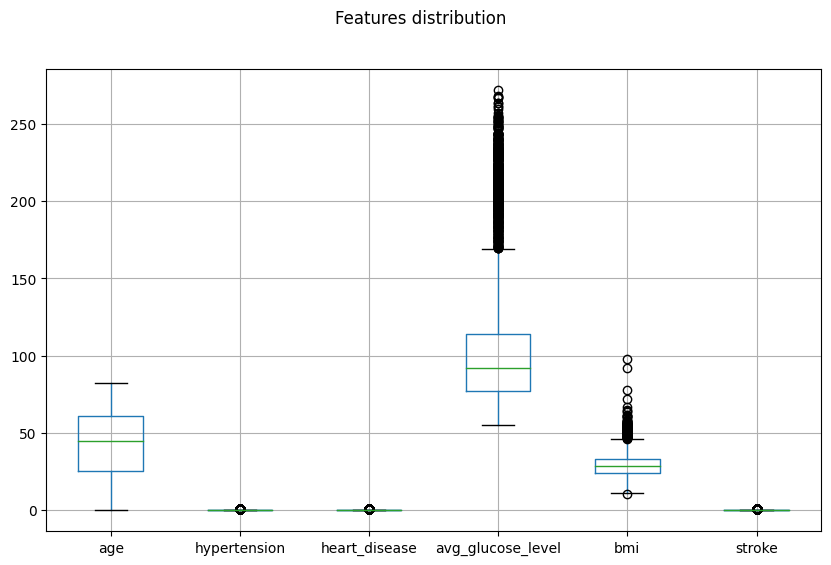

In [18]:
# check outliers
df_boxplot = df.boxplot(figsize= (10, 6))
plt.suptitle('Features distribution')

In [19]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,28.893237,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.000000,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.600000,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.600000,formerly smoked,0


### Outliers handling

In [20]:
df['avg_glucose_level'].max()

271.74

In [21]:
print("outliers: ", df[(df['avg_glucose_level']>= 210)].count())

outliers:  gender               315
age                  315
hypertension         315
heart_disease        315
ever_married         315
work_type            315
Residence_type       315
avg_glucose_level    315
bmi                  315
smoking_status       315
stroke               315
dtype: int64


In [22]:
df = df[(df['avg_glucose_level']<= 210)]

In [23]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1
5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.000000,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,28.893237,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.000000,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.600000,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.600000,formerly smoked,0


In [24]:
print("outliers: ", df[(df['bmi']>= 55)].count())

outliers:  gender               28
age                  28
hypertension         28
heart_disease        28
ever_married         28
work_type            28
Residence_type       28
avg_glucose_level    28
bmi                  28
smoking_status       28
stroke               28
dtype: int64


In [25]:
df = df[(df['bmi']<= 55)]

In [26]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1
5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.000000,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,28.893237,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.000000,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.600000,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.600000,formerly smoked,0


Text(0.5, 0.98, 'Features distribution')

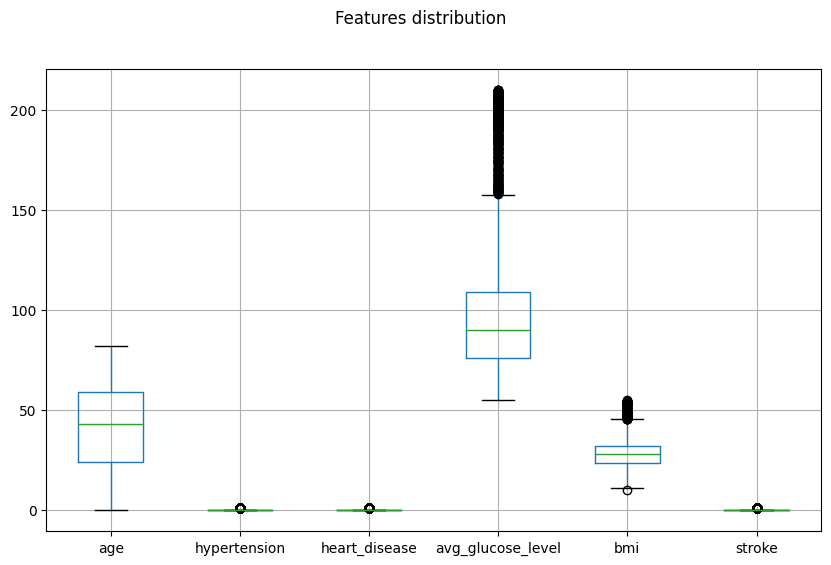

In [27]:
df_boxplot = df.boxplot(figsize= (10,6))
plt.suptitle("Features distribution")

### Categorical values handling

In [28]:
df['gender'].value_counts()

Female    2815
Male      1954
Other        1
Name: gender, dtype: int64

In [29]:
# handle categorical data (gender, ever_married, work_type, Residence_type, smoking_status)
df1= df[(df['gender'] != 'Other')]
df1['gender'].value_counts()

Female    2815
Male      1954
Name: gender, dtype: int64

In [30]:
df1.head(5)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1
5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.000000,formerly smoked,1


In [31]:
encoder = LabelEncoder()
df1 = df.apply(encoder.fit_transform)
df1.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,0,82,0,0,1,3,0,3567,162,2,1
2,1,101,0,1,1,2,0,2468,199,2,1
3,0,70,0,0,1,2,1,3365,218,3,1
4,0,100,1,0,1,3,0,3374,113,2,1
5,1,102,0,0,1,2,1,3428,164,1,1


### Checking correlation

<Axes: >

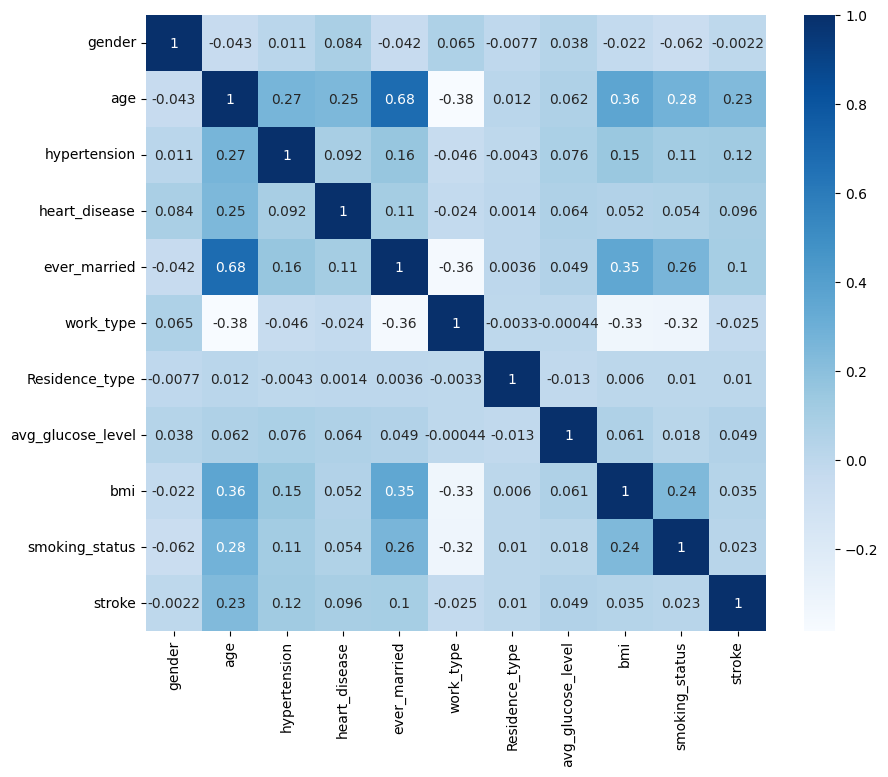

In [32]:
# plotting heatmap for correlation
plt.figure(figsize= (10,8))
sns.heatmap(df1.corr(), annot = True, cmap = 'Blues')

###Handling imbalanced data

In [33]:
# separating imabalanced data into 2 classes
df1_class_0 = df1[df1['stroke']== 0]
df1_class_1 = df1[df1['stroke']== 1]
class_0, class_1 = df1['stroke'].value_counts()

# sampling the minor class
df1_class_1 = df1_class_1.sample(class_0, replace= True)
# concatenating the dataframe back together
df1_over = pd.concat([df1_class_0, df1_class_1], axis = 0)
print(df1_over.stroke.value_counts())

0    4565
1    4565
Name: stroke, dtype: int64


In [34]:
# plot data after oversampling
df1_over['stroke'].value_counts(normalize= True)
fig = px.pie(df1_over, names = 'stroke', color_discrete_sequence= ['#89AED2', '#123F6A'], title = '% patient got stroke after oversampling')
fig.show()

In [35]:
X= df1_over.drop('stroke', axis= 1)
y= df1_over.stroke

# scaling data
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

# splitting data for training and testing
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42)
df1_over

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
249,1,24,0,0,0,4,0,1973,53,0,0
250,1,79,1,0,1,2,1,1591,266,2,0
251,0,29,0,0,0,2,1,2647,49,0,0
252,0,91,0,0,1,2,0,524,233,1,0
253,1,35,0,0,0,1,0,3321,64,0,0
...,...,...,...,...,...,...,...,...,...,...,...
31,1,63,0,0,1,2,0,1328,127,0,1
41,1,75,0,0,1,2,1,641,158,2,1
128,1,103,0,0,1,0,1,3549,164,1,1
48,1,102,0,0,1,3,1,2184,211,2,1


##**3. Modeling and evaluation**

##Optimized Random Forest

Best hyperparameters- Random forest:  {'class_weight': None, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 200}
Accuracy train:  1.0000
Accuaracy test:  0.9918
Classification report: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       905
           1       0.98      1.00      0.99       921

    accuracy                           0.99      1826
   macro avg       0.99      0.99      0.99      1826
weighted avg       0.99      0.99      0.99      1826



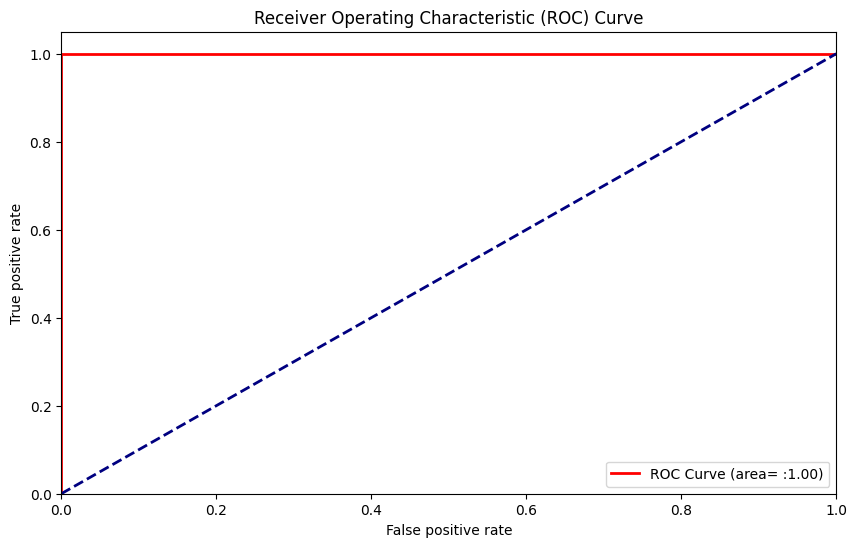

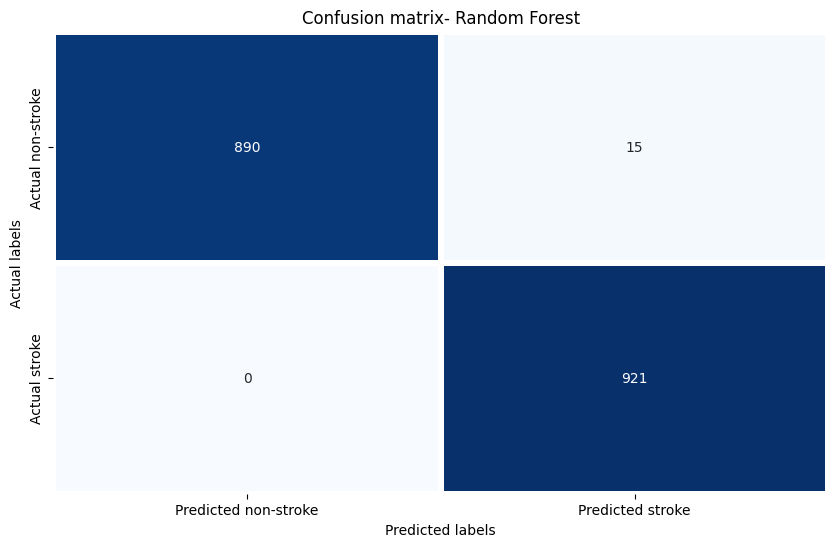

In [37]:
param_grid_rf = {'n_estimators': [50, 100, 200],
                 'max_depth': [None, 10, 20],
                 'min_samples_split': [2, 6, 10],
                 'min_samples_leaf': [1, 2, 4],
                 'max_features': ['sqrt', 'log2'],
                 'class_weight': ['balanced', 'balanced_subsample', None]}

rf = RandomForestClassifier(random_state= 42)

grid_search_rf = GridSearchCV(estimator= rf, param_grid= param_grid_rf, scoring= 'accuracy', cv= 5, n_jobs= -1)
grid_search_rf.fit(X_train_scaled, y_train)

best_param_rf= grid_search_rf.best_params_
best_rf = RandomForestClassifier(random_state= 42, **best_param_rf)
best_rf.fit(X_train_scaled, y_train)

y_pred_rf = best_rf.predict(X_test_scaled)

accuracy_train = best_rf.score(X_train_scaled, y_train)
accuracy_test_rf = accuracy_score(y_test, y_pred_rf)
print('Best hyperparameters- Random forest: ', best_param_rf)
print(f"Accuracy train: {accuracy_train: .4f}")
print(f"Accuaracy test: {accuracy_test_rf: .4f}")

# Classification report
class_rp_rf = classification_report(y_test, y_pred_rf)
print('Classification report: \n', class_rp_rf)

# ROC Curve
roc_auc_rf = roc_auc_score(y_test, best_rf.predict_proba(X_test_scaled)[:, 1])
fpr, tpr, _ = roc_curve(y_test, best_rf.predict_proba(X_test_scaled)[:, 1])

plt.figure(figsize= (10,6))
plt.plot(fpr, tpr, color= 'r', lw= 2, label= 'ROC Curve (area= :{:.2f})'.format(roc_auc_rf))
plt.plot([0,1], [0,1], color = 'navy', lw= 2, linestyle= '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc= 'lower right')
plt.show()

# Confusion martix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize = (10,6))
sns.heatmap(conf_matrix_rf, annot= True, fmt= 'd', cmap= 'Blues', linewidths= 3, cbar= False)
plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')
plt.title('Confusion matrix- Random Forest')
plt.xticks([0.5, 1.5], ['Predicted non-stroke', 'Predicted stroke'])
plt.yticks([0.5, 1.5], ['Actual non-stroke', 'Actual stroke'])
plt.show()


In [59]:
print(y_pred_rf[305])

1


In [61]:
# save and write model by using pickle
import pickle
pickle.dump(best_rf, open('saved_model.pkl', 'wb'))

In [52]:
# check the model again
with open('saved_model.pkl', 'rb') as file:
  data = pickle.load(file)
y_prd = data.predict(X_test_scaled)

0


In [60]:
print(y_prd[305])

1


In [ ]:
# ref
# https://www.kaggle.com/code/nimapourmoradi/healthcare-stroke
# https://www.kaggle.com/code/amirmahdiabbootalebi/99-accuracy-with-oversampling-visualization
# https://www.kaggle.com/code/bhavanaraj/stroke-prediction-analysis
# https://www.kaggle.com/code/x1wello1x/prediction-of-strokes
